# Codestral with self-correction

> Codestral is a cutting-edge generative model that has been specifically designed and optimized
for code generation tasks, including fill-in-the-middle and code completion. Codestral was trained
on 80+ programming languages, enabling it to perform well on both common and less common
languages

We can combine the code generation capabilities of Codestral the self-correction approach presented in the [AlphaCodium](https://github.com/Codium-ai/AlphaCodium) paper, [constructing an answer to a coding question iteratively](https://x.com/karpathy/status/1748043513156272416?s=20).  

We will implement some of these ideas from scratch using [LangGraph](https://python.langchain.com/docs/langgraph) to 1) produce structured code generation output from Codestral-instruct, 2) perform inline unit tests to confirm imports and code execution work, 3) feed back any errors for Codestral for self-correction.

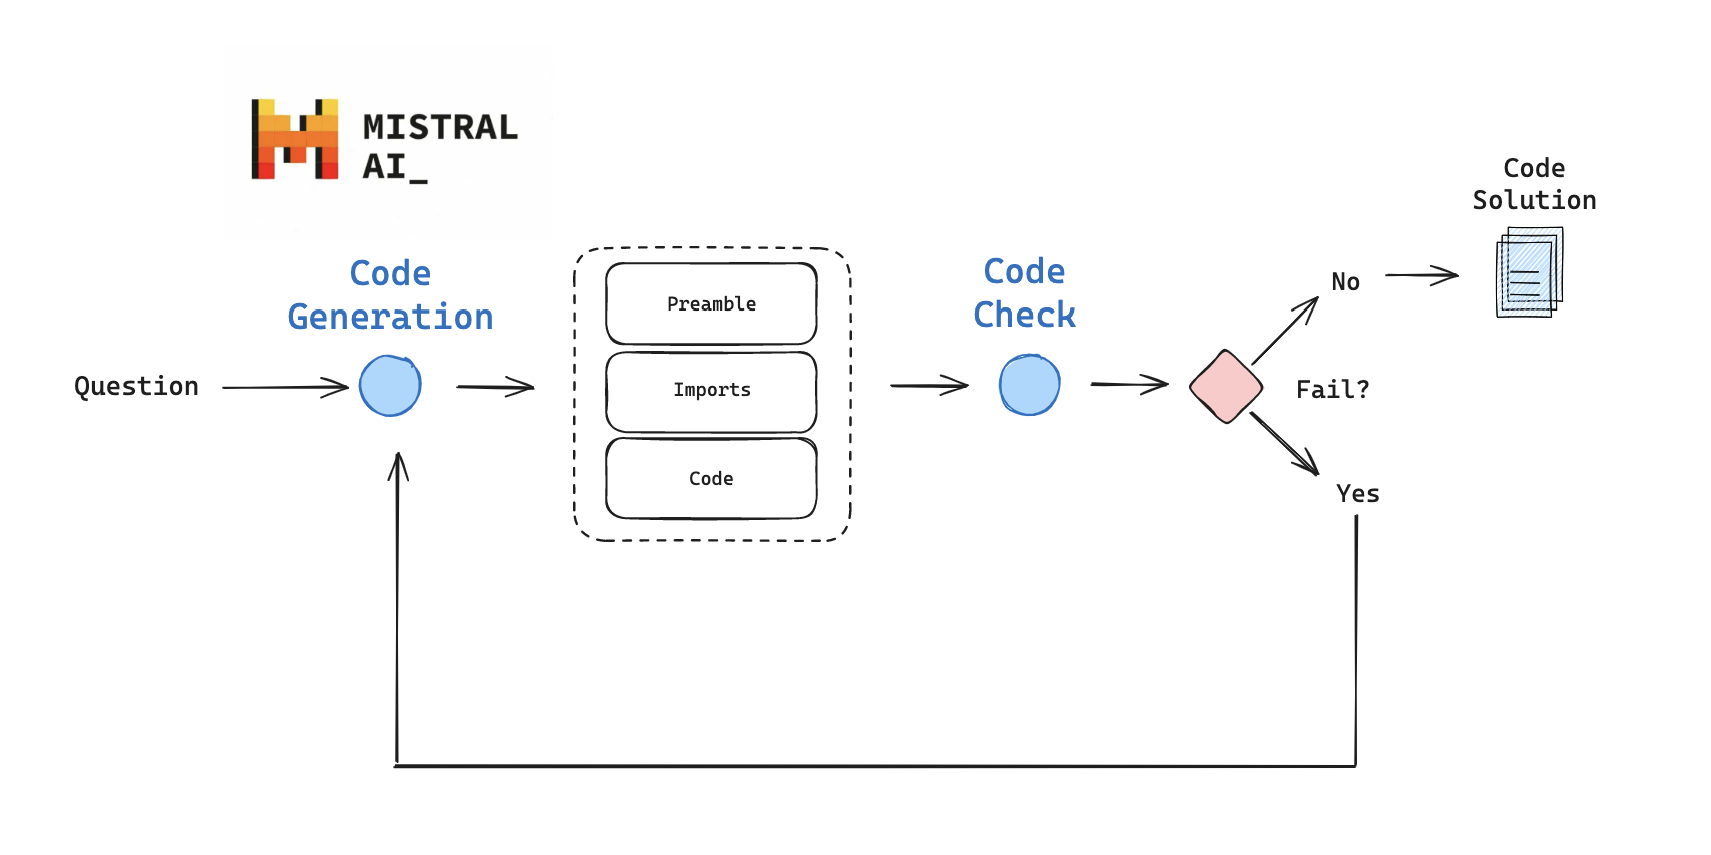!

In [2]:
! pip install -U -q langchain_community langchain-mistralai langchain langgraph

### LLM

We'll use the Mistral API and `Codestral` instruct model, which support tool use!

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("MISTRAL_API_KEY")
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

MISTRAL_API_KEY: ··········


Optionally, you can use [LangSmith](https://docs.smith.langchain.com/) for tracing.

In [ ]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "mistral-cookbook"

LANGCHAIN_API_KEY: ··········


## Code Generation

Test with structured output.

In [4]:
# Select LLM
from langchain_mistralai import ChatMistralAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Mistral model
mistral_model = "codestral-latest"
llm = ChatMistralAI(model=mistral_model, temperature=0) # deterministic output

# Prompt
# Define how the prompt sent to the LLM should look
code_gen_prompt_claude = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a coding assistant. Ensure any code you provide can be executed with all required imports and variables \n
            defined. Structure your answer: 1) a prefix describing the code solution, 2) the imports, 3) the functioning code block.
            \n Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)

# Data model
# Define how the model should structure its response
class code(BaseModel):
    """Schema for structured code solutions to programming questions."""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")

# LLM
structured_llm_claude = llm.with_structured_output(code, include_raw=False)

code_gen_chain = (
    code_gen_prompt_claude | structured_llm_claude
)

In [6]:
question = "Write a function for fibonacci in c."
messages = [("user", question)]

# Test
result = code_gen_chain.invoke({"messages": [("user", question)]})
result

code(prefix='The Fibonacci sequence is a series of numbers where each number is the sum of the two preceding ones, usually starting with 0 and 1. The Fibonacci sequence is defined by the recurrence relation: F(n) = F(n-1) + F(n-2), with base cases F(0) = 0 and F(1) = 1. This function will compute the nth Fibonacci number using an iterative approach to avoid the inefficiency of a recursive solution.', imports='#include <stdio.h>', code='int fibonacci(int n) {\n    if (n <= 1) {\n        return n;\n    }\n    int a = 0, b = 1, c;\n    for (int i = 2; i <= n; i++) {\n        c = a + b;\n        a = b;\n        b = c;\n    }\n    return b;\n}\n\nint main() {\n    int n;\n    printf("Enter the value of n: ");\n    scanf("%d", &n);\n    printf("Fibonacci number at position %d is %d\\n", n, fibonacci(n));\n    return 0;\n}')

# Graph

We build the above workflow as a graph using [LangGraph](https://langchain-ai.github.io/langgraph/).

### Graph state

The graph `state` schema contains keys that we want to:

* Pass to each node in our graph
* Optionally, modify in each node of our graph

See conceptual docs [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

In [7]:
from typing import Annotated
from typing import Dict, TypedDict, List
from langgraph.graph.message import AnyMessage, add_messages

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    # A list of message objects (e.g. user queries, model responses), annotated with a special function (`add_messages`)
    messages: Annotated[list[AnyMessage], add_messages]
    generation: str
    iterations: int

## Graph

In [8]:
from operator import itemgetter
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate

### Parameters
max_iterations = 5

### Nodes
def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---  GENERATING CODE SOLUTION  ---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state.get("error", "")

    # Solution
    code_solution = code_gen_chain.invoke(
        {"messages": messages}
    )
    messages += [
        (
            "assistant",
            f"Here is my attempt to solve the problem: {code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}

def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---  VALIDATING THE CODE  ---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    prefix = code_solution.prefix
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---  CODE IMPORT CHECK: FAILED  ---")
        error_message = [("user", f"Your solution failed the import test. Here is the error: {e}. Reflect on this error and your prior attempt to solve the problem. (1) State what you think went wrong with the prior solution and (2) try to solve this problem again. Return the FULL SOLUTION. Use the code tool to structure the output with a prefix, imports, and code block:")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        combined_code = f"{imports}\n{code}"
        # Use a shared scope for exec
        global_scope = {}
        exec(combined_code, global_scope)
    except Exception as e:
        print("---  CODE BLOCK CHECK: FAILED  ---")
        error_message = [("user", f"Your solution failed the code execution test: {e}) Reflect on this error and your prior attempt to solve the problem. (1) State what you think went wrong with the prior solution and (2) try to solve this problem again. Return the FULL SOLUTION. Use the code tool to structure the output with a prefix, imports, and code block:")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---  CODE TEST SUCCESSFUL  ---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }

### Conditional edges

def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---  DECISION: FINISH  ---")
        return "end"
    else:
        print("---  DECISION: RE-TRY SOLUTION  ---")
        return "generate"

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


We'll add persistence to the graph using [a checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/).

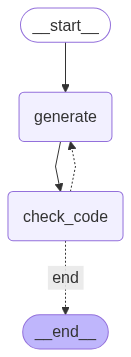

In [9]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph

# Define the graph
builder = StateGraph(GraphState)

# Define the nodes
builder.add_node("generate", generate)  # generation solution
builder.add_node("check_code", code_check)  # check code

# Build graph
builder.set_entry_point("generate")
builder.add_edge("generate", "check_code")
builder.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "generate": "generate",
    },
)

graph = builder.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [10]:
from langchain_core.messages import HumanMessage
question = "Write a function for fibonacci."
for event in graph.stream({"messages": [HumanMessage(content=question)], "iterations": 0}, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='Write a function for fibonacci.', additional_kwargs={}, response_metadata={}, id='09566689-18d8-41a6-b1e9-953cd8cb6c38')], 'iterations': 0}
---  GENERATING CODE SOLUTION  ---
{'messages': [HumanMessage(content='Write a function for fibonacci.', additional_kwargs={}, response_metadata={}, id='09566689-18d8-41a6-b1e9-953cd8cb6c38'), AIMessage(content='Here is my attempt to solve the problem: The Fibonacci sequence is a series of numbers where each number is the sum of the two preceding ones, usually starting with 0 and 1. The Fibonacci sequence is defined by the recurrence relation: F(n) = F(n-1) + F(n-2), with initial conditions F(0) = 0 and F(1) = 1. This function will compute the nth Fibonacci number using an iterative approach to ensure efficiency and avoid the potential stack overflow issues associated with a recursive approach. \n Imports:  \n Code: def fibonacci(n):\n    """Compute the nth Fibonacci number.\n    \n    Args:\n        n (int): The

`Trace:`

https://smith.langchain.com/public/a59ec940-f618-411d-adc9-1781816e7627/r

In [11]:
question = """Create a Python program that allows two players to play a game of Tic-Tac-Toe. The game should be played on a 3x3 grid. The program should:

- Allow players to take turns to input their moves.
- Check for invalid moves (e.g., placing a marker on an already occupied space).
- Determine and announce the winner or if the game ends in a draw.

Requirements:
- Use a 2D list to represent the Tic-Tac-Toe board.
- Use functions to modularize the code.
- Validate player input.
- Check for win conditions and draw conditions after each move."""

for event in graph.stream({"messages": [HumanMessage(content=question)], "iterations": 0}, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='Create a Python program that allows two players to play a game of Tic-Tac-Toe. The game should be played on a 3x3 grid. The program should:\n\n- Allow players to take turns to input their moves.\n- Check for invalid moves (e.g., placing a marker on an already occupied space).\n- Determine and announce the winner or if the game ends in a draw.\n\nRequirements:\n- Use a 2D list to represent the Tic-Tac-Toe board.\n- Use functions to modularize the code.\n- Validate player input.\n- Check for win conditions and draw conditions after each move.', additional_kwargs={}, response_metadata={}, id='b3a0e3ff-ae8e-4a99-8e46-e924216f0e28')], 'iterations': 0}
---  GENERATING CODE SOLUTION  ---
{'messages': [HumanMessage(content='Create a Python program that allows two players to play a game of Tic-Tac-Toe. The game should be played on a 3x3 grid. The program should:\n\n- Allow players to take turns to input their moves.\n- Check for invalid moves (e.g., placing a

Trace:

https://smith.langchain.com/public/4bd4cee1-75b1-453e-a7c4-ea3ae0249223/r

In [12]:
# from langchain_core.messages import HumanMessage
question = "Write a function for finding n prime numbers."
for event in graph.stream({"messages": [("user", question)], "iterations": 0}, stream_mode="values"):
    print(event)

# from langchain_core.messages import HumanMessage

# question = "Write a function for finding n prime numbers."

# for event in graph.stream({
#     "messages": [HumanMessage(content=question)],
#     "iterations": 0
# }, stream_mode="values"):
#     print(event)

# question = "Write a function for finding n prime numbers."
# solution = graph.invoke({"messages": [("user", question)], "iterations": 0})

{'messages': [HumanMessage(content='Write a function for finding n prime numbers.', additional_kwargs={}, response_metadata={}, id='f7543eaa-0b43-4e23-9755-e6929ffca54a')], 'iterations': 0}
---  GENERATING CODE SOLUTION  ---
{'messages': [HumanMessage(content='Write a function for finding n prime numbers.', additional_kwargs={}, response_metadata={}, id='f7543eaa-0b43-4e23-9755-e6929ffca54a'), AIMessage(content='Here is my attempt to solve the problem: This function generates the first n prime numbers. It uses a helper function to check if a number is prime. The main function iterates through numbers starting from 2, checks if they are prime, and collects them until it finds n primes. \n Imports: import math \n Code: def is_prime(num):\n    """Check if a number is prime."""\n    if num <= 1:\n        return False\n    if num == 2:\n        return True\n    if num % 2 == 0:\n        return False\n    for i in range(3, int(math.sqrt(num)) + 1, 2):\n        if num % i == 0:\n            r